# CORNER TRANSFER matrix

Following the great tutorial by Philippe Corboz [pdf](https://nextcloud.tfk.ph.tum.de/etn/wp-content/uploads/2018/11/Philippe_Corboz.pdf)

## Local Boltzmann weight

We start by defining the local Boltzmann weight
$$M(i,j) = \exp(-\beta(-\sigma_i \sigma_j - 0.5 h(\sigma_i +\sigma_j)))$$


In [1]:
import numpy as np
import scipy.linalg as LA
import matplotlib.pyplot as plt
from ncon import ncon
beta= np.log(1.+np.sqrt(2.))/2.
h = 0.0
#H =- s s -h s
Boltz_weight=np.zeros([2,2])
for s_1 in [0,1]:
    for s_2 in [0,1]:
        sigma_1=2.*(s_1-0.5)
        sigma_2=2.*(s_2-0.5)
        Boltz_weight[s_1,s_2]=(np.exp(beta*sigma_1*sigma_2+
                                           beta*h*0.5*(sigma_1+sigma_2)))

## Local Tensor
 We now build the elementary four legs tensor $$T$$ we will use for the contraction using the Boltzman weight and the copy tensor as in the left part of the figure, we will define a function that accepts two arguments $\beta, h$
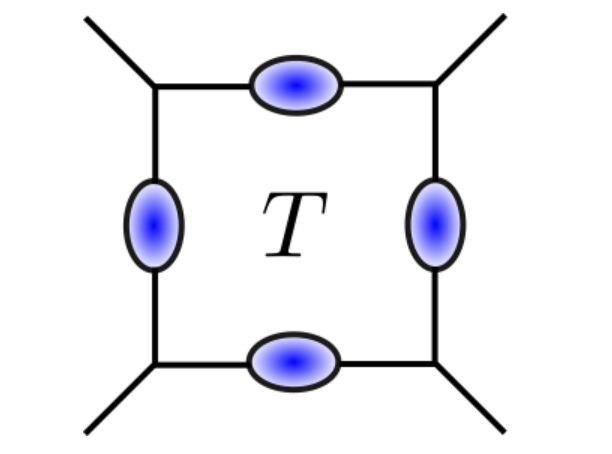

In [2]:
def local_tensor_T(beta, h):
#H =- s s -h s
    Boltz_weight=np.zeros([2,2])
    for s_1 in [0,1]:
        for s_2 in [0,1]:
            sigma_1=2.*(s_1-0.5)
            sigma_2=2.*(s_2-0.5)
            Boltz_weight[s_1,s_2]=(np.exp(beta*sigma_1*sigma_2+
                                               beta*h*0.5*(sigma_1+sigma_2)))    

    
    
    copy_3= np.zeros([2,2,2])
    #copy_4= np.zeros([2,2,2,2])
    
    for s in [0,1]:
        copy_3[s,s,s]=1.
        #copy_4[s,s,s,s]=1.
    
    list_tensors =[copy_3,
                   Boltz_weight,
                   copy_3,
                   Boltz_weight,
                   copy_3,
                   Boltz_weight,
                   copy_3,
                   Boltz_weight]    
    list_indices =[[-1,1,8],[1,2],[2,-2,3],[3,4],
                    [4,-3,5],[5,6],[6,-4,7],[7,8]]
    tensor_z_two_dim = ncon(list_tensors,list_indices)
    return tensor_z_two_dim

## Building blocks
Now  we need to code the two functions that perform the contraction of the partition function and the numerator for the magnetization, 
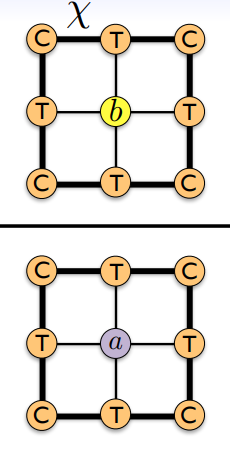

*** In this plot $$ a=T $$ of the previous figure
 $$C$$ and $$T$$,can be initialized as slices of $a$ as if some of the boundary spins of $a$, where set to $\uparrow$ (corresponding to the state $0$)
 
 we define two functions, one that compute the numerator and the other the denominator. The first will accept as input $ C, T, a$ while the second also requires $b$, as an alternative we can define also a function that compute both numerator and denominator and takes the ratio, to directly returnt the magnetization

In [3]:
def compute_norm(C,T,a):
    list_tensors=[C,C,C,C,T,T,T,T,a]
    list_indices=[[7,8],[1,2],[3,4],[5,6],
                     [8,12,1],[2,9,3],[4,10,5],[6,11,7],
                     [11,12,9,10]]
    norm=ncon(list_tensors,list_indices)
    return(norm)
def compute_mag(C,T,a,b):
    list_tensors=[C,C,C,C,T,T,T,T,a]
    list_indices=[[7,8],[1,2],[3,4],[5,6],
                 [8,12,1],[2,9,3],[4,10,5],[6,11,7],
                 [11,12,9,10]]
    norm=ncon(list_tensors,list_indices)
    list_tensors=[C,C,C,C,T,T,T,T,b]
    numerator=ncon(list_tensors,list_indices)
    return(numerator/norm)

## One step

Now the core of the CTM algortihm is to renormalize the $C$ and $T$ until a fixed point is obtained. 
This is done by absorbing at each step an extra $a$ into $C$ and $T$ and then truncating the resulting tensor so that their size is upperbounded by maximal bond dimension 
$$\chi \le \chi_{max}$$

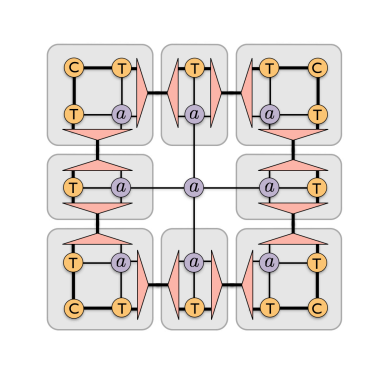

The recipy to project back is based on the spectrum of the CTM $C$

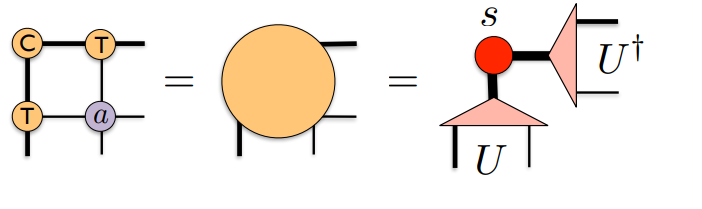

For stability reasons, it is important to keep norms and tensor bounded (by finding an adequate normalization step) and to keep the corner symmetric, such that one can use an eigenvalue decomposition rather than an svd. 

The projector thus project on the largest eigenvalues of the corner 

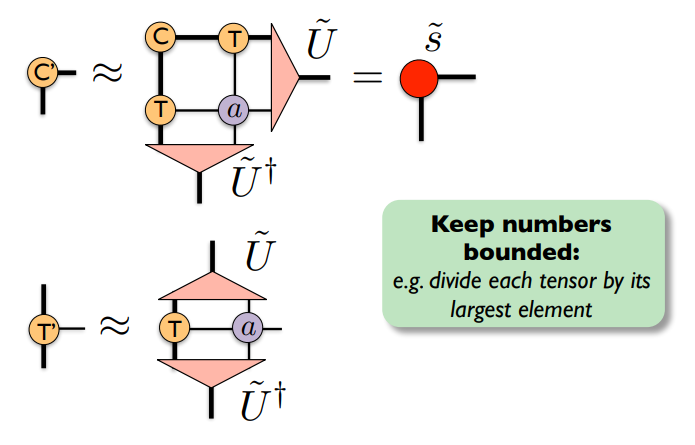

The function that perfrom such step requires, $C$, $T$, $a$, $d$,the size of $a$ $\chi$,the size of the corner $\chi_{max}$, the maximal size of the corner, d_tol, the cutoff on the eigenvalues. 

The size of the corner will grow up to $\chi_{max}$ by including all eigenvalues of the corner up to d_tol, the new chi should also be returned

In [4]:
def one_step_ctm(C,T,a,d,chi,chi_max,d_tol):
    Cp = ncon([C, T, T, a],[[2, 1], [1 ,3, -3], [-1,4,2],
                            [-2,4,3,-4]]).reshape(chi*d,chi*d)
    #print(T[:,0,:]-T[:,0,:].T)
    np.allclose(Cp,Cp.T)
    Cp =0.5*(Cp+Cp.T)
    e_c, U_c =LA.eigh(Cp)
    n_cp=np.max(e_c)
    Cp=Cp/n_cp
    e_c, U_c =LA.eigh(Cp)
    #print(max(e_c))
    Tp = ncon([T,a],[[-1,1,-4],[-3,-2,1,-5]]).reshape(chi*d,d,chi*d)
    Tp=Tp/n_cp
    chitemp = sum(e_c/np.max(e_c) > d_tol)
    chi= min(chitemp,chi_max)
    U_c= U_c[:, range(-1, -chi - 1, -1)]
    #print(chi)
    C=U_c.T.conj()@Cp@U_c
    T=ncon([U_c.T.conj(),U_c,Tp],
          [[-1,1],[2,-3],[1,-2,2]]) 
    return C, T,chi

In order to compare with the exact result we need to compute also the exact magnetization for $\beta\ge \beta_c$ given by 
$$M = \left[ 1 - \sinh^{-4}(2 \beta) \right]^{1/8}$$ 



In [5]:


def exact_mag(beta):
    return (1 - np.sinh(2*beta)**(-4))**(1/8)

## All together, several iterations

Now we can put all together, since the CTM is an iterative method one should take care about the convergence, by e.g. tracking the magnetization and repeating the algorithm untill it stop changing (up to a desired accuracy). For simplicity here we will fix the number of iteration to 40 and run the program for different $\beta$. 

In [6]:
d_tol=1.e-10

numiter=100
list_mag=[]
beta_start=0.42
b_fin=0.5
num_steps=100
d=2
chi_max=4
x = np.linspace(beta_start,b_fin,num_steps)
for beta in x:
    a=local_tensor_T(beta,0)
    b=a.copy()
    b[1,:,:,:]=-b[1,:,:,:]
    C = a[:,:,0,0]
    T = a[:,:,0,:]
    chi = d
    T = T+T.transpose([2,1,0])
    norm = compute_norm(C,T,a)
    C= C/norm**(1/9)
    T = T/norm**(1/9)
    for k in range(numiter+1):
        C,T,chi = one_step_ctm(C,T,a,d,chi,chi_max,d_tol)
        norm = compute_norm(C,T,a)
        C= C/norm**(1/9)
        T = T/norm**(1/9)
        magnetization = compute_mag(C,T,a,b)
        norm = compute_norm(C,T,a)
        print(k,norm, magnetization,chi)
    list_mag.append(magnetization)


0 1.1876471087375127 0.8017202429156474 4
1 1.4652517068087616 0.7439006729366326 4
2 1.4335881280899767 0.6960140544478425 4
3 1.4390579101559882 0.6535541179877477 4
4 1.4403658249386644 0.6144528712098806 4
5 1.4420945263412608 0.5776408301900389 4
6 1.4437371339305805 0.5425341293181434 4
7 1.4453439186240609 0.5088140039717314 4
8 1.4468987801941284 0.47631750264496064 4
9 1.4483912583925966 0.4449767024885769 4
10 1.4498102185126482 0.4147815660454484 4
11 1.451145751572818 0.38575554894728264 4
12 1.4523898074790007 0.3579388147749002 4
13 1.453536662763225 0.33137646231080375 4
14 1.45458312554429 0.306110352565672 4
15 1.45552851970857 0.28217368073412796 4
16 1.4563744879589435 0.25958770190351327 4
17 1.457124664230115 0.23836014659960947 4
18 1.4577842686804385 0.21848493118719314 4
19 1.4583596748211016 0.19994281678628384 4
20 1.458857989676138 0.18270271545392933 4
21 1.459286676535429 0.16672338930167474 4
22 1.4596532381397251 0.1519553367460547 4
23 1.45996496773815 0

9 1.4490563656806466 0.4683490598322606 4
10 1.450456495368147 0.4399781498005893 4
11 1.4517918680083954 0.4125745229560076 4
12 1.4530548384970108 0.38615317148884987 4
13 1.4542391112617592 0.36074147723298833 4
14 1.4553400397175495 0.33637139393365917 4
15 1.4563547773991772 0.31307385635488744 4
16 1.457282293463173 0.2908749045302098 4
17 1.4581232735690226 0.2697931686209887 4
18 1.458879932446099 0.24983844071654998 4
19 1.4595557671460586 0.231011104415521 4
20 1.4601552794710662 0.2133022220523275 4
21 1.4606836928294062 0.19669410335842247 4
22 1.4611466836966964 0.18116120263934637 4
23 1.4615501419750716 0.16667121542814567 4
24 1.4618999687467715 0.15318626965858131 4
25 1.462201914861505 0.1406641296944414 4
26 1.4624614598370402 0.12905935302450103 4
27 1.4626837277907314 0.11832435830345804 4
28 1.4628734354710493 0.10841037924737008 4
29 1.463034866728926 0.099268291565756 4
30 1.4631718677236076 0.09084930977724932 4
31 1.4632878575680563 0.08310555772935067 4
32 1.

17 1.4589311611303069 0.30323099165398504 4
18 1.4597730725063283 0.283587084545776 4
19 1.4605419390248198 0.26485898903763505 4
20 1.4612397560847765 0.2470514791333626 4
21 1.4618693651221304 0.23016315420990738 4
22 1.4624342782756834 0.21418652097386137 4
23 1.4629385012928733 0.19910833511289877 4
24 1.4633863649034646 0.184910125799808 4
25 1.4637823721238128 0.17156883743003673 4
26 1.4641310662207074 0.15905753415468907 4
27 1.4644369216207225 0.14734612359078297 4
28 1.4647042580545397 0.13640206618787154 4
29 1.4649371767366248 0.12619104580354515 4
30 1.4651395163877075 0.11667758489339394 4
31 1.465314826349146 0.10782559426898371 4
32 1.465466353829863 0.09959885263232902 4
33 1.4655970423755729 0.0919614151426973 4
34 1.4657095388714008 0.08487795324426756 4
35 1.465806206710366 0.07831403003840885 4
36 1.4658891431254624 0.07223631678591198 4
37 1.465960199052194 0.06661275682922452 4
38 1.466021000234849 0.06141268347451535 4
39 1.4660729685984137 0.056606898291094825 

21 1.4627942041556556 0.2668742679539472 4
22 1.4634568604844256 0.2508527960870204 4
23 1.4640620619798757 0.23556586115973746 4
24 1.4646123026730902 0.22100894336976046 4
25 1.4651104429675408 0.2071738333295375 4
26 1.4655596069839714 0.19404888315576366 4
27 1.4659630867188058 0.18161933469448038 4
28 1.4663242559418939 0.16986769665392673 4
29 1.4666464956266907 0.15877414713146917 4
30 1.4669331317143062 0.148316942510317 4
31 1.4671873852046273 0.1384728178607502 4
32 1.4674123339567817 0.1292173677244582 4
33 1.4676108851605063 0.12052539943401222 4
34 1.467785757187713 0.11237125389895708 4
35 1.467939469420581 0.10472909108006277 4
36 1.4680743386466348 0.09757313920042404 4
37 1.4681924806821076 0.09087790814803418 4
38 1.4682958160054553 0.0846183685606418 4
39 1.4683860783310259 0.07877009880450912 4
40 1.4684648252116208 0.07330940251895374 4
41 1.468533449915674 0.06821339964966158 4
42 1.4685931939718326 0.06346009398208988 4
43 1.4686451599060477 0.05902842015245541 4

22 1.4641656186353909 0.29072250970790925 4
23 1.4648595724135038 0.27567385365345304 4
24 1.4655044010501967 0.2611964698661477 4
25 1.4661013293936531 0.24729094497056947 4
26 1.4666519206758888 0.23395562794186656 4
27 1.4671580191005797 0.22118663615736958 4
28 1.4676216916424865 0.20897793008977908 4
29 1.4680451713049187 0.19732144050442785 4
30 1.4684308036278717 0.18620723397375025 4
31 1.468780997774438 0.17562370441421385 4
32 1.469098183079078 0.1655577801794027 4
33 1.4693847715415034 0.15599513798609047 4
34 1.4696431264097578 0.14692041658219968 4
35 1.4698755367224072 0.13831742456242593 4
36 1.4700841974733954 0.13016933808143968 4
37 1.470271194919635 0.12245888539503987 4
38 1.4704384964636612 0.11516851617369807 4
39 1.470587944502101 0.1082805543838163 4
40 1.4707212536260048 0.10177733422835038 4
41 1.4708400105816706 0.09564131919289506 4
42 1.4709456764421902 0.0898552046704946 4
43 1.4710395904935283 0.08440200495453534 4
44 1.4711229753983384 0.0792651256103332

26 1.4673226773620023 0.2782825383309662 4
27 1.4679212816765657 0.26565178971859593 4
28 1.4684817435516906 0.2534510115098687 4
29 1.4690050607788163 0.24167924584275047 4
30 1.4694924098092397 0.2303343331411501 4
31 1.4699451164309068 0.21941292399619974 4
32 1.4703646264668429 0.20891051864085008 4
33 1.4707524773119316 0.1988215280379305 4
34 1.4711102709690844 0.18913935128174564 4
35 1.471439649089407 0.17985646466330726 4
36 1.4717422703711445 0.17096451837070772 4
37 1.472019790535374 0.16245443738656995 4
38 1.4722738449762804 0.15431652369932047 4
39 1.4725060340828895 0.14654055745963865 4
40 1.4727179111480164 0.13911589518396897 4
41 1.4729109727183274 0.13203156353053414 4
42 1.4730866511954752 0.12527634754868477 4
43 1.47324630947019 0.11883887262958906 4
44 1.4733912373565485 0.1127076796665861 4
45 1.4735226495900924 0.10687129316924776 4
46 1.473641685158429 0.10131828226952812 4
47 1.4737494077444404 0.09603731471473799 4
48 1.4738468070780175 0.09101720406476431 

38 1.4735587670139054 0.20272744646151308 4
39 1.4738905814972973 0.19441433448017753 4
40 1.4742002845760682 0.18638911682664236 4
41 1.4744889342139893 0.1786468795010314 4
42 1.4747575929356906 0.17118232368509953 4
43 1.4750073191149118 0.16398980794017343 4
44 1.475239159287041 0.1570633908854093 4
45 1.4754541414829514 0.15039687360665402 4
46 1.4756532695586375 0.14398384117584218 4
47 1.4758375184772072 0.13781770277892197 4
48 1.4760078304861204 0.1318917300567647 4
49 1.4761651121229347 0.12619909335848936 4
50 1.4763102319765797 0.12073289569018421 4
51 1.4764440191279906 0.11548620421483086 4
52 1.4765672621931971 0.11045207922176523 4
53 1.4766807088933023 0.10562360053684489 4
54 1.4767850660785853 0.10099389138854994 4
55 1.4768810001380464 0.09655613978114287 4
56 1.4769691377305072 0.09230361745477365 4
57 1.4770500667787663 0.08822969653457949 4
58 1.4771243376738634 0.08432786398745251 4
59 1.4771924646421737 0.08059173401678928 4
60 1.4772549272336781 0.077015058533

50 1.477947563610686 0.17362539169306007 4
51 1.4781707476490864 0.16768567454602998 4
52 1.478380897594271 0.1619251254608851 4
53 1.4785786185644252 0.15634034383142284 4
54 1.4787645053066445 0.15092783190150458 4
55 1.4789391401684475 0.14568400907798829 4
56 1.4791030913636527 0.14060522584096197 4
57 1.4792569115176186 0.13568777715264094 4
58 1.4794011364747506 0.1309279152862126 4
59 1.4795362843498052 0.12632186201388262 4
60 1.4796628548036312 0.12186582010931563 4
61 1.4797813285235666 0.11755598413380496 4
62 1.479892166888701 0.11338855048787166 4
63 1.4799958118006082 0.10935972672063192 4
64 1.4800926856606154 0.10546574009852049 4
65 1.4801831914756651 0.10170284544273074 4
66 1.480267713075648 0.09806733225107658 4
67 1.48034661542622 0.09455553112544877 4
68 1.4804202450222927 0.09116381953010795 4
69 1.4804889303485325 0.0878886269095088 4
70 1.4805529823944494 0.0847264391966812 4
71 1.4806126952127814 0.08167380274501883 4
72 1.4806683465111254 0.07872732771735613 

61 1.4812586400405845 0.18070398027777373 4
62 1.481457980653355 0.17593779815025945 4
63 1.481648377915259 0.1712823867147595 4
64 1.4818301445882898 0.1667361387703136 4
65 1.4820035902927629 0.16229741112266724 4
66 1.4821690207836897 0.15796452835250577 4
67 1.482326737298982 0.1537357865623546 4
68 1.4824770359777713 0.14960945707629236 4
69 1.4826202073465806 0.14558379007010086 4
70 1.4827565358707642 0.1416570181127809 4
71 1.482886299568269 0.13782735960327228 4
72 1.4830097696825089 0.1340930220890548 4
73 1.4831272104110025 0.13045220545566727 4
74 1.4832388786862782 0.12690310497857524 4
75 1.483345024005482 0.12344391423083798 4
76 1.4834458883051183 0.12007282784178668 4
77 1.483541705877334 0.11678804410368789 4
78 1.4836327033242878 0.1135877674247722 4
79 1.483719099547133 0.11047021062828334 4
80 1.4838011057663434 0.10743359709840646 4
81 1.4838789255701572 0.10447616277480679 4
82 1.4839527549881382 0.1015961579984997 4
83 1.4840227825869239 0.09879184921232974 4
84

62 1.4811244242859254 0.2585423420440696 4
63 1.4813997831529397 0.2539326555824084 4
64 1.4816677627787387 0.24939064357299628 4
65 1.481928472466496 0.2449158377316603 4
66 1.4821820245986297 0.24050776209513797 4
67 1.482428534386697 0.23616593220848425 4
68 1.4826681196182914 0.2318898544776081 4
69 1.4829009004024807 0.2276790256715949 4
70 1.4831269989153775 0.22353293256059312 4
71 1.4833465391472314 0.2194510516760935 4
72 1.483559646652279 0.2154328491814496 4
73 1.4837664483025566 0.21147778084133625 4
74 1.483967072046664 0.20758529207971682 4
75 1.4841616466744312 0.20375481811661533 4
76 1.4843503015883024 0.1999857841747341 4
77 1.4845331665821002 0.19627760574759343 4
78 1.4847103716278345 0.19262968892153426 4
79 1.4848820466710344 0.18904143074444385 4
80 1.4850483214349923 0.18551221963467907 4
81 1.4852093252343253 0.182041435824112 4
82 1.4853651867980258 0.17862845182974088 4
83 1.4855160341022438 0.17527263294871692 4
84 1.4856619942128493 0.17197333777212684 4
85

69 1.4803281144500813 0.32890420883140115 4
70 1.4805908796359788 0.32542757569852515 4
71 1.4808497608621094 0.32198401907838226 4
72 1.4811047910807007 0.31857316952512643 4
73 1.4813560032058817 0.31519467223065967 4
74 1.4816034301483358 0.3118481859795641 4
75 1.481847104845842 0.3085333821771319 4
76 1.482087060289981 0.30524994394507765 4
77 1.4823233295492386 0.30199756527995164 4
78 1.4825559457888167 0.2987759502696503 4
79 1.4827849422873358 0.29558481236393247 4
80 1.4830103524506622 0.2924238736950516 4
81 1.4832322098230897 0.28929286444505387 4
82 1.4834505480960258 0.28619152225644945 4
83 1.4836654011144035 0.2831195916833442 4
84 1.4838768028809777 0.28007682368026254 4
85 1.4840847875586374 0.27706297512613076 4
86 1.4842893894709714 0.2740778083811006 4
87 1.4844906431011033 0.2711210908740369 4
88 1.4846885830890764 0.2681925947186547 4
89 1.4848832442277924 0.2652920963564775 4
90 1.485074661457711 0.2624193762248562 4
91 1.4852628698603851 0.259574218448474 4
92 

74 1.4764786312449767 0.4221543668051219 4
75 1.4766703918103987 0.42005441385983405 4
76 1.4768602054660998 0.41797417532850434 4
77 1.4770481063243872 0.41591322134258946 4
78 1.4772341274427079 0.4138711376553104 4
79 1.47741830086989 0.4118475248780245 4
80 1.4776006576898393 0.4098419977630914 4
81 1.4777812280628408 0.40785418452988714 4
82 1.4779600412646277 0.40588372623084634 4
83 1.47813712572337 0.4039302761547074 4
84 1.4783125090547093 0.4019934992643501 4
85 1.4784862180949787 0.4000730716668473 4
86 1.4786582789326776 0.3981686801134924 4
87 1.4788287169383798 0.3962800215278221 4
88 1.4789975567931117 0.39440680255972344 4
89 1.4791648225153156 0.3925487391639241 4
90 1.4793305374864907 0.3907055562012722 4
91 1.479494724475576 0.38887698706131635 4
92 1.4796574056621559 0.387062773304842 4
93 1.479818602658564 0.3852626643251086 4
94 1.4799783365309185 0.3834764170265863 4
95 1.48013662781921 0.3817037955201495 4
96 1.480293496556419 0.3799445708336902 4
97 1.480448962

89 1.4722930069730973 0.5041874163700415 4
90 1.4723703643027726 0.5034269924097626 4
91 1.4724465668746187 0.502678328904838 4
92 1.472521638274583 0.5019411693447758 4
93 1.4725956014253256 0.501215265104979 4
94 1.472668478610749 0.5005003751249549 4
95 1.4727402914993746 0.49979626560294477 4
96 1.4728110611666692 0.49910270970596526 4
97 1.4728808081163511 0.4984194872943307 4
98 1.4729495523007405 0.4977463846597941 4
99 1.473017313140201 0.4970831942764929 4
100 1.4730841095417266 0.4964297145639586 4
0 1.1937461223868242 0.8445210614925338 4
1 1.4825981772278005 0.8086589943991723 4
2 1.4485207686912973 0.7829161595782108 4
3 1.453286316925537 0.7629327153567058 4
4 1.4536615644894695 0.7466585200439118 4
5 1.4544414352401307 0.7329706183306767 4
6 1.4551084470758875 0.7211880464712576 4
7 1.4557309833217698 0.7108669313028141 4
8 1.4563094755866677 0.7017019433026341 4
9 1.4568501346214167 0.6934741183966746 4
10 1.4573573043301344 0.6860211236923375 4
11 1.4578346403489806 0.

98 1.467586184407355 0.5820279217592234 4
99 1.4676041137347555 0.5818574968674587 4
100 1.4676215263570866 0.5816920527172661 4
0 1.1942789613240221 0.8475249157680896 4
1 1.4840718800498083 0.8130751168673283 4
2 1.4498116290871472 0.788679340468895 4
3 1.4545361547551832 0.7699959167203099 4
4 1.4548521950728253 0.7549844436342791 4
5 1.4555717933868615 0.7425277308105748 4
6 1.4561757996382088 0.731948542067344 4
7 1.4567331186101997 0.7228055918860518 4
8 1.4572444758507466 0.7147954508819921 4
9 1.457716378481671 0.7077006147534097 4
10 1.4581534337829594 0.7013599142089213 4
11 1.4585595308173576 0.6956506474730992 4
12 1.4589379263665463 0.6904772722322826 4
13 1.4592913880560254 0.6857639653765005 4
14 1.4596222900874316 0.6814495649380906 4
15 1.4599326865938203 0.6774840342603339 4
16 1.4602243680606275 0.6738259300450993 4
17 1.4604989055551307 0.6704405507840867 4
18 1.4607576858673286 0.6672985574873527 4
19 1.461001939762661 0.6643749292588934 4
20 1.461232764932665 0.66

11 1.4593431466309237 0.7109359254751054 4
12 1.459657960616277 0.706682832719855 4
13 1.4599478555549321 0.7028638477466002 4
14 1.4602153625207333 0.6994187053362008 4
15 1.4604626714122886 0.6962981919379823 4
16 1.4606916902056644 0.6934616274506026 4
17 1.460904091603716 0.6908750238889697 4
18 1.461101350236008 0.6885097138936478 4
19 1.4612847726633933 0.6863413123272186 4
20 1.4614555218222791 0.6843489184812895 4
21 1.4616146371184293 0.6825144950369422 4
22 1.461763051079341 0.6808223788475722 4
23 1.4619016032575383 0.6792588913895167 4
24 1.4620310519182238 0.677812025513004 4
25 1.462152083926708 0.6764711912723659 4
26 1.462265323162162 0.6752270079806478 4
27 1.4623713377165948 0.6740711327794493 4
28 1.4624706460860972 0.6729961183108653 4
29 1.4625637225209112 0.6719952937744925 4
30 1.4626510016695229 0.671062664919353 4
31 1.4627328826270178 0.6701928294766956 4
32 1.4628097324782083 0.6693809052681403 4
33 1.4628818894102844 0.6686224687837145 4
34 1.462949665457047

24 1.4622374721390936 0.6999873311892836 4
25 1.4623183263673014 0.6990971507988666 4
26 1.4623927025104062 0.6982846055992805 4
27 1.4624611568853432 0.6975420870140977 4
28 1.4625241926201924 0.696862856123167 4
29 1.462582265533936 0.6962409257189753 4
30 1.4626357892486137 0.6956709612075802 4
31 1.4626851396518439 0.6951481968780556 4
32 1.4627306588066074 0.6946683647888698 4
33 1.4627726583886962 0.69422763407657 4
34 1.4628114227185969 0.693822558923947 4
35 1.4628472114437794 0.6934500337622498 4
36 1.4628802619183883 0.6931072545476294 4
37 1.4629107913200705 0.6927916851625299 4
38 1.4629389985376315 0.6925010281607398 4
39 1.4629650658582625 0.6922331992097196 4
40 1.4629891604788712 0.6919863046927436 4
41 1.4630114358626545 0.6917586220218854 4
42 1.4630320329590796 0.6915485822851188 4
43 1.463051081303016 0.6913547549100774 4
44 1.463068700006636 0.6911758340759003 4
45 1.4630849986560426 0.6910106266450735 4
46 1.4631000781229107 0.6908580414208608 4
47 1.4631140313002

38 1.4630570654168293 0.7148476794402951 4
39 1.463070295545445 0.7147107881404172 4
40 1.4630823007189941 0.7145868304129088 4
41 1.463093196066377 0.7144745467973883 4
42 1.4631030856200256 0.7143728065918244 4
43 1.4631120634290546 0.7142805937142054 4
44 1.4631202145540172 0.714196994267799 4
45 1.4631276159568314 0.7141211855819702 4
46 1.463134337297804 0.7140524265344196 4
47 1.463140441650186 0.713990048989092 4
48 1.4631459861413951 0.7139334502077539 4
49 1.463151022528938 0.7138820861132835 4
50 1.4631555977181354 0.7138354652996224 4
51 1.4631597542278936 0.7137931436976673 4
52 1.4631635306100497 0.7137547198185539 4
53 1.4631669618271546 0.7137198305061765 4
54 1.4631700795930962 0.7136881471396421 4
55 1.4631729126803492 0.7136593722339761 4
56 1.4631754871972922 0.7136332363939057 4
57 1.4631778268386806 0.7136094955811831 4
58 1.4631799531119287 0.7135879286607641 4
59 1.4631818855416876 0.7135683351953396 4
60 1.463183641854847 0.7135505334613756 4
61 1.46318523814791

47 1.4634935266933617 0.7332005886254674 4
48 1.463495851925893 0.7331765178031073 4
49 1.4634979245345852 0.7331550749333064 4
50 1.46349977207382 0.7331359708129824 4
51 1.4635014190716418 0.7331189485135491 4
52 1.4635028873661007 0.7331037796930714 4
53 1.4635041964035134 0.7330902613459599 4
54 1.4635053635030155 0.7330782129353692 4
55 1.4635064040913885 0.7330674738608325 4
56 1.4635073319115333 0.7330579012199865 4
57 1.4635081592076788 0.7330493678286226 4
58 1.4635088968899306 0.7330417604679373 4
59 1.4635095546805514 0.7330349783318479 4
60 1.4635101412440195 0.7330289316506634 4
61 1.4635106643027112 0.7330235404703717 4
62 1.4635111307398088 0.7330187335693801 4
63 1.4635115466908841 0.7330144474967595 4
64 1.4635119176254014 0.7330106257179891 4
65 1.463512248419289 0.7330072178558867 4
66 1.463512543419545 0.7330041790158548 4
67 1.4635128065017713 0.7330014691859006 4
68 1.463513041121415 0.7329990527029675 4
69 1.4635132503594412 0.7329968977781245 4
70 1.463513436962

52 1.4640873376378165 0.7493700634261535 4
53 1.4640878290582933 0.7493649084728684 4
54 1.4640882589337116 0.7493603999945587 4
55 1.4640886349812765 0.7493564567269082 4
56 1.4640889639484058 0.7493530076642982 4
57 1.4640892517350705 0.749349990754948 4
58 1.4640895035006107 0.7493473517642213 4
59 1.464089723756985 0.7493450432839364 4
60 1.4640899164502252 0.7493430238685566 4
61 1.4640900850315959 0.7493412572817159 4
62 1.4640902325197664 0.74933971183876 4
63 1.4640903615551302 0.7493383598328857 4
64 1.4640904744472962 0.7493371770341067 4
65 1.4640905732165814 0.7493361422517082 4
66 1.4640906596303076 0.7493352369520412 4
67 1.4640907352345052 0.7493344449246169 4
68 1.4640908013816603 0.7493337519903217 4
69 1.4640908592549602 0.749333145746419 4
70 1.4640909098895076 0.7493326153436618 4
71 1.464090954190865 0.7493321512914489 4
72 1.4640909929512753 0.749331745287481 4
73 1.4640910268638505 0.7493313900688193 4
74 1.464091056534984 0.7493310792816518 4
75 1.4640910824952 

61 1.4648510589151105 0.7633285171880115 4
62 1.464851105039172 0.7633280262176987 4
63 1.4648511446287777 0.7633276048154757 4
64 1.4648511786098273 0.7633272431208064 4
65 1.4648512077769864 0.7633269326715825 4
66 1.464851232812298 0.7633266662055878 4
67 1.4648512543011474 0.7633264374902055 4
68 1.4648512727459664 0.763326241176333 4
69 1.4648512885779992 0.7633260726730529 4
70 1.4648513021673797 0.7633259280401054 4
71 1.4648513138318089 0.7633258038956257 4
72 1.4648513238439704 0.7633256973369762 4
73 1.464851332437917 0.7633256058728144 4
74 1.464851339814549 0.7633255273647909 4
75 1.4648513461463004 0.7633254599775255 4
76 1.4648513515811787 0.7633254021356677 4
77 1.4648513562462282 0.76332535248705 4
78 1.4648513602504947 0.7633253098710644 4
79 1.4648513636875748 0.7633252732915183 4
80 1.4648513666378127 0.7633252418933433 4
81 1.4648513691701628 0.7633252149425974 4
82 1.4648513713438205 0.7633251918093064 4
83 1.464851373209593 0.7633251719527346 4
84 1.46485137481109

71 1.4657469563464074 0.7755411811112641 4
72 1.4657469589138645 0.7755411533766728 4
73 1.4657469610759453 0.7755411300211618 4
74 1.4657469628966542 0.7755411103532915 4
75 1.4657469644298908 0.775541093790802 4
76 1.4657469657210471 0.775541079843373 4
77 1.465746966808344 0.7755410680981056 4
78 1.4657469677239678 0.7755410582072954 4
79 1.4657469684950257 0.7755410498781402 4
80 1.465746969144341 0.7755410428640684 4
81 1.4657469696911372 0.7755410369574406 4
82 1.465746970151603 0.7755410319834037 4
83 1.4657469705393633 0.7755410277947109 4
84 1.4657469708659034 0.7755410242673644 4
85 1.465746971140885 0.7755410212969448 4
86 1.465746971372451 0.7755410187955201 4
87 1.465746971567457 0.7755410166890407 4
88 1.4657469717316713 0.7755410149151493 4
89 1.4657469718699598 0.7755410134213343 4
90 1.4657469719864125 0.7755410121633749 4
91 1.46574697208448 0.7755410111040326 4
92 1.4657469721670626 0.7755410102119473 4
93 1.465746972236606 0.7755410094607113 4
94 1.465746972295174 0

81 1.4667464198109201 0.7863633361999154 4
82 1.4667464199080267 0.786363335136228 4
83 1.466746419988255 0.7863633342574071 4
84 1.4667464200545421 0.7863633335313234 4
85 1.4667464201093061 0.786363332931431 4
86 1.466746420154554 0.786363332435799 4
87 1.4667464201919382 0.7863633320263057 4
88 1.4667464202228224 0.7863633316879816 4
89 1.4667464202483411 0.7863633314084579 4
90 1.4667464202694256 0.7863633311775147 4
91 1.4667464202868445 0.7863633309867089 4
92 1.4667464203012366 0.7863633308290643 4
93 1.466746420313127 0.786363330698818 4
94 1.4667464203229494 0.7863633305912082 4
95 1.4667464203310676 0.7863633305023006 4
96 1.4667464203377722 0.7863633304288453 4
97 1.466746420343312 0.786363330368156 4
98 1.4667464203478908 0.7863633303180142 4
99 1.4667464203516731 0.786363330276587 4
100 1.4667464203547957 0.7863633302423602 4
0 1.1990495256154572 0.8707953348665728 4
1 1.4970703801652432 0.8465320952309282 4
2 1.461315545922179 0.8313662440060271 4
3 1.4657918039222682 0.8

86 1.4678280654287423 0.7960648183756929 4
87 1.4678280654358893 0.7960648182963582 4
88 1.4678280654416849 0.7960648182320481 4
89 1.4678280654463807 0.796064818179917 4
90 1.4678280654501887 0.7960648181376585 4
91 1.467828065453277 0.7960648181034025 4
92 1.467828065455778 0.7960648180756335 4
93 1.4678280654578062 0.7960648180531237 4
94 1.4678280654594502 0.7960648180348767 4
95 1.4678280654607834 0.7960648180200851 4
96 1.4678280654618623 0.7960648180080947 4
97 1.4678280654627385 0.7960648179983751 4
98 1.4678280654634492 0.7960648179904966 4
99 1.4678280654640223 0.7960648179841099 4
100 1.4678280654644908 0.7960648179789324 4
0 1.1996376856388031 0.8732815810865262 4
1 1.4986526095053836 0.8500201135768516 4
2 1.4627282390512417 0.8357059701777703 4
3 1.4671862093833985 0.8262067388235889 4
4 1.4670832159308156 0.8196115715167371 4
5 1.467401216200312 0.8148949294255645 4
6 1.4676060620869356 0.8114509948357183 4
7 1.467771953568309 0.8088976677091028 4
8 1.4679019583695552 0.

100 1.468976485316491 0.8048450998185198 4
0 1.2002312070680152 0.8757179894265946 4
1 1.5002454609684803 0.8534206549423595 4
2 1.4641526997405152 0.8399148970114778 4
3 1.4685944250565002 0.831097299259377 4
4 1.468460850443998 0.8250774167360269 4
5 1.4687523053739169 0.8208457246343319 4
6 1.468932872198676 0.8178097316449972 4
7 1.4690770715055608 0.8155987278118357 4
8 1.4691879220387523 0.8139700279883313 4
9 1.4692737049746012 0.812759409653491 4
10 1.4693401004389504 0.8118529458836654 4
11 1.4693915454099469 0.8111700768484038 4
12 1.4694314443323258 0.8106529782908325 4
13 1.4694624192821926 0.8102596467195385 4
14 1.469486490603345 0.8099592736592965 4
15 1.4695052162504385 0.8097290800032914 4
16 1.4695197985045165 0.8095521091702588 4
17 1.4695311659122958 0.8094156652731783 4
18 1.4695400362349678 0.809310194009493 4
19 1.4695469648296937 0.8092284725433271 4
20 1.4695523818449465 0.809165018055366 4
21 1.46955662082311 0.8091156528287613 4
22 1.469559940702108 0.8090771

7 1.47040543156074 0.821946275215401 4
8 1.4704997589901883 0.8205632604152634 4
9 1.4705713852154259 0.8195540419279921 4
10 1.4706257655676047 0.8188122627091172 4
11 1.4706670939340383 0.8182637551209578 4
12 1.4706985316888974 0.8178560632387767 4
13 1.4707224699081227 0.8175516677995458 4
14 1.4707407169695614 0.8173234869921465 4
15 1.4707546412641135 0.817151824256521 4
16 1.4707652788303227 0.817022261951275 4
17 1.4707734146393605 0.8169241875126052 4
18 1.4707796439544238 0.8168497505040395 4
19 1.4707844186371193 0.8167931177275497 4
20 1.4707880820859556 0.8167499371036168 4
21 1.4707908955963402 0.8167169492806857 4
22 1.4707930582517514 0.8166917046650658 4
23 1.470794721940172 0.8166723562094804 4
24 1.4707960026985292 0.8166575069708235 4
25 1.4707969892915287 0.816646097471061 4
26 1.4707977497069742 0.8166373221225572 4
27 1.470798336080527 0.8166305669709205 4
28 1.4707987884354732 0.8166253631401853 4
29 1.4707991375271927 0.8166213518924202 4
30 1.470799407010304 0

9 1.4718957715357945 0.8259497605092223 4
10 1.4719402181659529 0.8253436596846337 4
11 1.4719733475627583 0.8249037667333198 4
12 1.471998063922369 0.8245828482946801 4
13 1.4720165231531652 0.8243476592937314 4
14 1.4720303250191804 0.8241745971220744 4
15 1.4720406570084463 0.8240467835619 4
16 1.4720484010085406 0.8239520741873056 4
17 1.4720542124305176 0.8238816831472593 4
18 1.4720585788310543 0.823829223300768 4
19 1.4720618633140499 0.8237900305973934 4
20 1.4720643366481503 0.8237606851674926 4
21 1.472066201030719 0.8237386697864503 4
22 1.4720676076749584 0.823722124995467 4
23 1.4720686698335794 0.823709672659879 4
24 1.4720694724523309 0.8237002882509931 4
25 1.4720700793345296 0.823693207988695 4
26 1.4720705384663848 0.8236878610425918 4
27 1.4720708859818596 0.8236838198266933 4
28 1.472071149119944 0.8236807634161531 4
29 1.4720713484343837 0.823678450521928 4
30 1.4720714994477453 0.8236766994569015 4
31 1.472071613891706 0.8236753732372855 4
32 1.472071700638546 0.8

10 1.473281481278387 0.8314828386148773 4
11 1.4733079884906888 0.8311305236468328 4
12 1.4733273839997305 0.8308782487367609 4
13 1.4733415919516575 0.8306967725460416 4
14 1.4733520127945114 0.830565684141314 4
15 1.4733596660793882 0.8304706371357614 4
16 1.4733652944245275 0.8304014869799842 4
17 1.4733694391781222 0.8303510218513321 4
18 1.4733724953969989 0.8303140898310902 4
19 1.4733747517577618 0.8302869939669804 4
20 1.4733764195143781 0.8302670702443942 4
21 1.4733776535074519 0.8302523914641982 4
22 1.4733785674134783 0.8302415583762117 4
23 1.4733792448231107 0.8302335516348504 4
24 1.4733797472995607 0.8302276263731542 4
25 1.4733801202496892 0.8302232367861027 4
26 1.4733803972091697 0.8302199819448554 4
27 1.4733806029762735 0.8302175667015231 4
28 1.4733807559081187 0.830215773369526 4
29 1.4733808696065345 0.8302144411332937 4
30 1.4733809541580833 0.8302134510266219 4
31 1.4733810170477395 0.8302127149398426 4
32 1.4733810638331526 0.8302121675532071 4
33 1.473381098

13 1.4746950159052388 0.8366425556720166 4
14 1.474702872494785 0.8365433625605185 4
15 1.4747085338183736 0.8364727500043251 4
16 1.474712619325065 0.8364223066391959 4
17 1.4747155719575327 0.8363861569864672 4
18 1.4747177088502936 0.8363601767496508 4
19 1.4747192574071533 0.8363414576208763 4
20 1.474720380963516 0.8363279399822741 4
21 1.4747211970437366 0.836318159418585 4
22 1.4747217903600147 0.8363110708620057 4
23 1.4747222220789038 0.8363059259851803 4
24 1.4747225364378997 0.8363021873060978 4
25 1.4747227654790682 0.8362994677305208 4
26 1.4747229324425697 0.8362974878069667 4
27 1.47472305420477 0.83629604537565 4
28 1.4747231430336112 0.8362949939317054 4
29 1.474723207855029 0.836294227144208 4
30 1.4747232551682818 0.8362936677431132 4
31 1.4747232897086888 0.8362932595184348 4
32 1.4747233149281935 0.8362929615454251 4
33 1.4747233333442675 0.8362927440073407 4
34 1.4747233467935268 0.8362925851682359 4
35 1.474723356616249 0.8362924691757802 4
36 1.4747233637907384 

13 1.4760744345583827 0.842223535657829 4
14 1.476080350959907 0.8421485369558286 4
15 1.4760845343133155 0.8420961153358899 4
16 1.4760874970507998 0.8420593422577918 4
17 1.4760895986335645 0.8420334625338908 4
18 1.4760910915950929 0.8420151962801031 4
19 1.476092153657419 0.8420022706158321 4
20 1.47609291012906 0.8419931035934225 4
21 1.4760934495336038 0.8419865896824029 4
22 1.4760938345273242 0.8419819534059513 4
23 1.4760941095383366 0.8419786489640306 4
24 1.4760943061225411 0.8419762910501563 4
25 1.4760944467271127 0.8419746069375672 4
26 1.4760945473411777 0.8419734031431849 4
27 1.4760946193670523 0.8419725421342815 4
28 1.4760946709441412 0.841971925988207 4
29 1.47609470788752 0.8419714848890207 4
30 1.4760947343545734 0.841971169003896 4
31 1.4760947533192565 0.8419709427307145 4
32 1.4760947669099505 0.8419707806152897 4
33 1.476094776650466 0.8419706644479509 4
34 1.4760947836320981 0.8419705811954733 4
35 1.4760947886365758 0.8419705215260496 4
36 1.476094792223993 

22 1.4774918263458519 0.8472975504914483 4
23 1.4774920014862667 0.8472954287271891 4
24 1.477492124391332 0.8472939420768941 4
25 1.4774922106878066 0.8472928995032529 4
26 1.4774922713072316 0.8472921678311771 4
27 1.4774923139051437 0.8472916540526442 4
28 1.4774923438478627 0.8472912931134813 4
29 1.4774923648999208 0.8472910394552563 4
30 1.4774923797038602 0.8472908611405605 4
31 1.4774923901155776 0.8472907357624724 4
32 1.4774923974390348 0.8472906475903939 4
33 1.4774924025907008 0.8472905855751337 4
34 1.4774924062148744 0.8472905419526015 4
35 1.4774924087645964 0.8472905112653747 4
36 1.4774924105584768 0.8472904896764578 4
37 1.47749241182062 0.847290474487629 4
38 1.477492412708659 0.8472904638011862 4
39 1.4774924133334961 0.8472904562822955 4
40 1.4774924137731447 0.8472904509919587 4
41 1.4774924140824912 0.8472904472695878 4
42 1.4774924143001618 0.8472904446504335 4
43 1.47749241445332 0.8472904428075141 4
44 1.4774924145610886 0.8472904415107692 4
45 1.4774924146369

36 1.478913708499642 0.8522903701046919 4
37 1.4789137091192461 0.8522903625798407 4
38 1.478913709547129 0.8522903573834767 4
39 1.4789137098426213 0.8522903537949954 4
40 1.4789137100466874 0.8522903513168382 4
41 1.4789137101876184 0.8522903496054348 4
42 1.478913710284945 0.852290348423537 4
43 1.4789137103521601 0.8522903476073109 4
44 1.47891371039858 0.8522903470436174 4
45 1.478913710430637 0.8522903466543231 4
46 1.4789137104527792 0.8522903463854713 4
47 1.4789137104680679 0.8522903461997976 4
48 1.478913710478628 0.8522903460715683 4
49 1.4789137104859198 0.8522903459830108 4
50 1.4789137104909567 0.8522903459218516 4
51 1.4789137104944363 0.8522903458796133 4
52 1.4789137104968364 0.8522903458504429 4
53 1.4789137104984966 0.8522903458302977 4
54 1.478913710499639 0.8522903458163845 4
55 1.4789137105004313 0.852290345806776 4
56 1.47891371050098 0.8522903458001403 4
57 1.4789137105013563 0.8522903457955577 4
58 1.4789137105016168 0.8522903457923927 4
59 1.478913710501798 0.

50 1.4803565868549662 0.8570023207656343 4
51 1.4803565868562822 0.8570023207495132 4
52 1.4803565868571746 0.8570023207385851 4
53 1.480356586857779 0.8570023207311773 4
54 1.4803565868581898 0.8570023207261562 4
55 1.4803565868584656 0.8570023207227522 4
56 1.4803565868586546 0.8570023207204449 4
57 1.480356586858783 0.8570023207188809 4
58 1.4803565868588673 0.8570023207178208 4
59 1.4803565868589281 0.8570023207171023 4
60 1.4803565868589674 0.857002320716615 4
61 1.480356586858992 0.8570023207162846 4
62 1.4803565868590138 0.8570023207160609 4
63 1.4803565868590232 0.857002320715909 4
64 1.4803565868590338 0.8570023207158063 4
65 1.480356586859039 0.8570023207157366 4
66 1.4803565868590431 0.8570023207156893 4
67 1.4803565868590443 0.8570023207156573 4
68 1.4803565868590476 0.8570023207156358 4
69 1.4803565868590494 0.8570023207156209 4
70 1.4803565868590485 0.8570023207156109 4
71 1.4803565868590487 0.8570023207156043 4
72 1.4803565868590498 0.8570023207155997 4
73 1.480356586859

63 1.4818192689170389 0.8614539464114228 4
64 1.4818192689170406 0.8614539464113918 4
65 1.4818192689170409 0.8614539464113715 4
66 1.4818192689170433 0.861453946411358 4
67 1.4818192689170433 0.861453946411349 4
68 1.4818192689170444 0.8614539464113428 4
69 1.4818192689170453 0.8614539464113387 4
70 1.481819268917045 0.8614539464113359 4
71 1.4818192689170449 0.8614539464113341 4
72 1.4818192689170462 0.861453946411333 4
73 1.4818192689170462 0.8614539464113321 4
74 1.4818192689170444 0.8614539464113317 4
75 1.4818192689170446 0.8614539464113314 4
76 1.4818192689170444 0.8614539464113311 4
77 1.4818192689170462 0.8614539464113309 4
78 1.4818192689170455 0.8614539464113309 4
79 1.4818192689170457 0.8614539464113306 4
80 1.4818192689170455 0.8614539464113309 4
81 1.4818192689170457 0.8614539464113306 4
82 1.4818192689170457 0.8614539464113306 4
83 1.4818192689170457 0.8614539464113306 4
84 1.4818192689170444 0.8614539464113308 4
85 1.4818192689170449 0.8614539464113306 4
86 1.4818192689

77 1.483300243749005 0.865669017527169 4
78 1.483300243749005 0.865669017527169 4
79 1.4833002437490057 0.8656690175271687 4
80 1.4833002437490055 0.865669017527169 4
81 1.4833002437490057 0.8656690175271687 4
82 1.4833002437490064 0.8656690175271687 4
83 1.483300243749005 0.865669017527169 4
84 1.4833002437490057 0.8656690175271687 4
85 1.4833002437490057 0.8656690175271687 4
86 1.4833002437490068 0.8656690175271688 4
87 1.4833002437490068 0.8656690175271688 4
88 1.4833002437490066 0.8656690175271687 4
89 1.4833002437490066 0.8656690175271687 4
90 1.4833002437490066 0.8656690175271687 4
91 1.4833002437490042 0.8656690175271688 4
92 1.4833002437490053 0.865669017527169 4
93 1.4833002437490073 0.8656690175271688 4
94 1.4833002437490053 0.8656690175271686 4
95 1.4833002437490057 0.8656690175271687 4
96 1.4833002437490042 0.8656690175271688 4
97 1.4833002437490053 0.865669017527169 4
98 1.4833002437490057 0.8656690175271687 4
99 1.4833002437490068 0.8656690175271688 4
100 1.48330024374900

90 1.4847982109937636 0.8696682075508219 4
91 1.4847982109937647 0.869668207550822 4
92 1.4847982109937636 0.8696682075508219 4
93 1.4847982109937654 0.8696682075508217 4
94 1.4847982109937647 0.8696682075508216 4
95 1.4847982109937645 0.869668207550822 4
96 1.4847982109937663 0.8696682075508219 4
97 1.4847982109937645 0.869668207550822 4
98 1.4847982109937647 0.869668207550822 4
99 1.484798210993765 0.8696682075508217 4
100 1.4847982109937663 0.8696682075508219 4
0 1.2074155170182161 0.9004340079281167 4
1 1.5192792079189732 0.8868631806850077 4
2 1.4813140659420172 0.8800731369709385 4
3 1.4856888166055915 0.8764368842561926 4
4 1.4853293459879173 0.8744119683381246 4
5 1.4854485987494261 0.8732558588023132 4
6 1.4854846000910007 0.8725842410438522 4
7 1.4855111058682924 0.8721889946516127 4
8 1.4855270339318298 0.8719539868825584 4
9 1.485536941183289 0.871813044190588 4
10 1.4855430725467271 0.8717278758160537 4
11 1.4855468783749608 0.8716760601230102 4
12 1.485549245684838 0.8716

100 1.4863120444236269 0.8734695950733298 4
0 1.2080692423306991 0.9023196112504271 4
1 1.5209926257801274 0.8893309420334221 4
2 1.4828687161812615 0.8829432331040495 4
3 1.4872458432125653 0.8795829479135833 4
4 1.4868746919776021 0.8777455791230734 4
5 1.4869867809421926 0.8767158036370047 4
6 1.4870174852976856 0.8761286363655916 4
7 1.4870402916471823 0.8757894891454043 4
8 1.487053666063834 0.8755915640738471 4
9 1.4870618346652245 0.8754750437075753 4
10 1.487066793453043 0.8754059182906762 4
11 1.4870698140678424 0.8753646241189154 4
12 1.4870716582368049 0.8753397986512551 4
13 1.4870727872814127 0.8753247871379358 4
14 1.487073480403954 0.8753156622916274 4
15 1.487073907026418 0.8753100898596586 4
16 1.48707417024096 0.8753066730643206 4
17 1.4870743329767457 0.8753045707993456 4
18 1.4870744337695767 0.8753032736122055 4
19 1.48707449628966 0.8753024713089924 4
20 1.4870745351166408 0.8753019741490456 4
21 1.487074559252758 0.8753016656133096 4
22 1.487074574267996 0.875301

0 1.2087272745924165 0.9041666666328666 4
1 1.5227147760676243 0.8917361854291372 4
2 1.4844325205417057 0.885727882870247 4
3 1.488813017712327 0.8826232808307305 4
4 1.488431057898794 0.8809565130809829 4
5 1.4885367602049573 0.8800395182005293 4
6 1.4885628170608303 0.8795263219234457 4
7 1.4885824441720332 0.8792353836474369 4
8 1.488593667279285 0.8790687242391729 4
9 1.4886004000313746 0.8789724087295713 4
10 1.4886044092890836 0.8789163088843233 4
11 1.488606806242795 0.8788834000420122 4
12 1.4886082427494094 0.8788639693299443 4
13 1.4886091062154359 0.878852428431538 4
14 1.4886096267270144 0.8788455370799134 4
15 1.4886099413498997 0.8788414027186837 4
16 1.488610131985485 0.8788389123096022 4
17 1.4886102477381695 0.8788374070342967 4
18 1.4886103181469916 0.8788364946324451 4
19 1.4886103610368822 0.8788359403268721 4
20 1.488610387194115 0.8788356029590294 4
21 1.4886104031614193 0.8788353973322203 4
22 1.4886104129154991 0.8788352718627686 4
23 1.4886104188773874 0.87883

1 1.5244455345284265 0.8940805617934632 4
2 1.486005309885855 0.8884299276755351 4
3 1.4903901104637205 0.8855621132610488 4
4 1.4899981428912061 0.8840504529044803 4
5 1.4900981586880901 0.8832340839239103 4
6 1.4901201411425928 0.8827856434470093 4
7 1.4901370384928891 0.8825361114870747 4
8 1.4901464507107753 0.8823958004022447 4
9 1.4901519985407483 0.8823161936419095 4
10 1.4901552393555917 0.8822706660094954 4
11 1.4901571411997583 0.8822444384544499 4
12 1.4901582601409773 0.8822292283423722 4
13 1.4901589205483121 0.882220354020701 4
14 1.4901593114949714 0.8822151482270199 4
15 1.490159543571984 0.8822120799565392 4
16 1.4901596816791611 0.8822102642037347 4
17 1.490159764039007 0.8822091860337757 4
18 1.4901598132402152 0.8822085440588611 4
19 1.4901598426745455 0.8822081609587132 4
20 1.4901598603034343 0.8822079319419973 4
21 1.4901598708711712 0.882207794849386 4
22 1.4901598772104152 0.88220771269776 4
23 1.490159881015127 0.8822076634297729 4
24 1.490159883299562 0.88220

3 1.4919768989182354 0.8884035127564326 4
4 1.4915756580085184 0.8870328073112967 4
5 1.4916706171951595 0.8863061747815256 4
6 1.4916890301994368 0.8859143948671778 4
7 1.4917035856049496 0.8857004100246788 4
8 1.4917114745709126 0.8855822942600002 4
9 1.4917160451602938 0.8855165004892148 4
10 1.4917186643944038 0.8854795517045096 4
11 1.4917201733279284 0.8854586468953273 4
12 1.4917210449470621 0.8854467386077551 4
13 1.4917215501152814 0.8854399131730997 4
14 1.4917218438084672 0.8854359795699321 4
15 1.491722015042174 0.8854337017674391 4
16 1.4917221151261721 0.8854323774523719 4
17 1.491722173747117 0.8854316049234064 4
18 1.4917222081417834 0.8854311530554149 4
19 1.4917222283501843 0.8854308881801799 4
20 1.4917222402365258 0.8854307326548858 4
21 1.4917222472338727 0.8854306412174744 4
22 1.491722251355812 0.885430587405813 4
23 1.4917222537851293 0.8854305557135396 4
24 1.4917222552174119 0.8854305370379834 4
25 1.4917222560620933 0.8854305260283024 4
26 1.4917222565603463 

8 1.4932882385421347 0.8886369477031979 4
9 1.4932920035937707 0.8885825700781417 4
10 1.4932941202427878 0.8885525814504497 4
11 1.4932953174535917 0.888535916774264 4
12 1.4932959964843233 0.8885265915928798 4
13 1.4932963829748822 0.8885213406013499 4
14 1.493296603662674 0.8885183673630199 4
15 1.4932967300426698 0.8885166757980262 4
16 1.4932968025971152 0.8885157095549642 4
17 1.4932968443375043 0.8885151558098056 4
18 1.4932968683914205 0.8885148376259655 4
19 1.4932968822717942 0.8885146544163482 4
20 1.4932968902899395 0.8885145487545448 4
21 1.4932968949254661 0.8885144877414228 4
22 1.4932968976070513 0.888514452477241 4
23 1.4932968991590354 0.8885144320810812 4
24 1.4932969000575627 0.8885144202781651 4
25 1.493296900577904 0.8885144134453815 4
26 1.4932969008792947 0.8885144094887168 4
27 1.4932969010538861 0.8885144071970515 4
28 1.4932969011550403 0.8885144058695376 4
29 1.4932969012136457 0.8885144051004514 4
30 1.493296901247607 0.8885144046548508 4
31 1.4932969012672

13 1.4948828668880165 0.8914738903266758 4
14 1.4948830327651672 0.8914716422214135 4
15 1.4948831260719275 0.8914703855482016 4
16 1.4948831786889947 0.8914696802838648 4
17 1.4948832084219357 0.8914692831998262 4
18 1.4948832252514213 0.8914690590555863 4
19 1.4948832347897458 0.8914689322776779 4
20 1.4948832402011913 0.8914688604602934 4
21 1.4948832432736785 0.891468819729345 4
22 1.4948832450191811 0.8914687966085905 4
23 1.4948832460112482 0.8914687834755727 4
24 1.4948832465752773 0.8914687760121507 4
25 1.4948832468960245 0.8914687717692134 4
26 1.4948832470784588 0.8914687693564823 4
27 1.4948832471822366 0.8914687679842301 4
28 1.4948832472412752 0.8914687672036464 4
29 1.494883247274865 0.8914687667595793 4
30 1.4948832472939768 0.8914687665069352 4
31 1.4948832473048481 0.8914687663631902 4
32 1.4948832473110376 0.8914687662814015 4
33 1.4948832473145588 0.8914687662348637 4
34 1.4948832473165625 0.8914687662083831 4
35 1.4948832473177005 0.8914687661933153 4
36 1.49488324

21 1.4964807789897754 0.8943021955340045 4
22 1.4964807801266093 0.8943021803672293 4
23 1.496480780761148 0.8943021719063596 4
24 1.496480781115428 0.8943021671842765 4
25 1.496480781313277 0.8943021645479671 4
26 1.496480781423784 0.8943021630757761 4
27 1.4964807814855148 0.8943021622535179 4
28 1.4964807815199987 0.8943021617942064 4
29 1.4964807815392671 0.8943021615376121 4
30 1.4964807815500338 0.8943021613942568 4
31 1.4964807815560484 0.8943021613141623 4
32 1.4964807815594083 0.8943021612694105 4
33 1.4964807815612877 0.894302161244406 4
34 1.496480781562336 0.8943021612304343 4
35 1.496480781562921 0.8943021612226276 4
36 1.4964807815632495 0.8943021612182653 4
37 1.4964807815634331 0.894302161215828 4
38 1.4964807815635355 0.894302161214466 4
39 1.496480781563592 0.894302161213705 4
40 1.4964807815636245 0.8943021612132797 4
41 1.496480781563642 0.894302161213042 4
42 1.496480781563653 0.8943021612129092 4
43 1.4964807815636558 0.8943021612128349 4
44 1.4964807815636612 0.8

36 1.498089040079197 0.8970223417646203 4
37 1.498089040079288 0.8970223417634013 4
38 1.498089040079338 0.8970223417627321 4
39 1.4980890400793647 0.8970223417623652 4
40 1.4980890400793798 0.8970223417621638 4
41 1.4980890400793907 0.8970223417620531 4
42 1.4980890400793918 0.8970223417619927 4
43 1.4980890400793958 0.8970223417619594 4
44 1.4980890400793987 0.897022341761941 4
45 1.4980890400793987 0.8970223417619309 4
46 1.4980890400793971 0.8970223417619254 4
47 1.4980890400793987 0.8970223417619226 4
48 1.4980890400794018 0.897022341761921 4
49 1.4980890400793996 0.89702234176192 4
50 1.4980890400794007 0.8970223417619194 4
51 1.498089040079399 0.8970223417619191 4
52 1.4980890400793976 0.897022341761919 4
53 1.4980890400793996 0.8970223417619188 4
54 1.498089040079399 0.8970223417619188 4
55 1.4980890400794002 0.8970223417619189 4
56 1.4980890400793963 0.8970223417619185 4
57 1.4980890400794011 0.8970223417619186 4
58 1.4980890400793967 0.8970223417619186 4
59 1.4980890400793987

44 1.4997076022090159 0.899636348603701 4
45 1.4997076022090174 0.8996363486036967 4
46 1.4997076022090163 0.8996363486036942 4
47 1.4997076022090179 0.8996363486036928 4
48 1.499707602209017 0.8996363486036922 4
49 1.4997076022090183 0.899636348603692 4
50 1.4997076022090177 0.8996363486036917 4
51 1.4997076022090172 0.8996363486036916 4
52 1.499707602209016 0.8996363486036916 4
53 1.4997076022090157 0.8996363486036915 4
54 1.4997076022090179 0.8996363486036913 4
55 1.499707602209017 0.8996363486036916 4
56 1.4997076022090168 0.8996363486036916 4
57 1.499707602209017 0.8996363486036913 4
58 1.499707602209017 0.8996363486036913 4
59 1.4997076022090174 0.8996363486036913 4
60 1.4997076022090163 0.8996363486036912 4
61 1.499707602209017 0.8996363486036913 4
62 1.499707602209017 0.8996363486036913 4
63 1.4997076022090174 0.8996363486036913 4
64 1.4997076022090163 0.8996363486036912 4
65 1.499707602209017 0.8996363486036913 4
66 1.4997076022090174 0.8996363486036913 4
67 1.4997076022090163

55 1.5013360850834507 0.9021505958330117 4
56 1.5013360850834525 0.9021505958330118 4
57 1.5013360850834507 0.9021505958330117 4
58 1.5013360850834525 0.9021505958330118 4
59 1.501336085083452 0.9021505958330118 4
60 1.5013360850834523 0.9021505958330118 4
61 1.5013360850834525 0.9021505958330118 4
62 1.501336085083452 0.9021505958330118 4
63 1.5013360850834523 0.9021505958330118 4
64 1.5013360850834525 0.9021505958330118 4
65 1.501336085083452 0.9021505958330118 4
66 1.5013360850834523 0.9021505958330118 4
67 1.5013360850834525 0.9021505958330118 4
68 1.5013360850834507 0.9021505958330117 4
69 1.5013360850834525 0.9021505958330118 4
70 1.5013360850834505 0.902150595833012 4
71 1.5013360850834525 0.9021505958330118 4
72 1.5013360850834507 0.9021505958330117 4
73 1.5013360850834525 0.9021505958330118 4
74 1.5013360850834507 0.9021505958330117 4
75 1.5013360850834525 0.9021505958330118 4
76 1.501336085083452 0.9021505958330118 4
77 1.5013360850834523 0.9021505958330118 4
78 1.50133608508

68 1.5029741389722784 0.9045709435704833 4
69 1.5029741389722757 0.9045709435704832 4
70 1.5029741389722762 0.9045709435704832 4
71 1.5029741389722762 0.9045709435704832 4
72 1.5029741389722762 0.9045709435704832 4
73 1.5029741389722762 0.9045709435704832 4
74 1.5029741389722762 0.9045709435704832 4
75 1.5029741389722762 0.9045709435704832 4
76 1.502974138972275 0.9045709435704834 4
77 1.5029741389722777 0.9045709435704833 4
78 1.502974138972275 0.9045709435704834 4
79 1.5029741389722762 0.9045709435704832 4
80 1.5029741389722762 0.9045709435704832 4
81 1.5029741389722762 0.9045709435704832 4
82 1.5029741389722777 0.9045709435704833 4
83 1.5029741389722755 0.9045709435704832 4
84 1.502974138972277 0.9045709435704833 4
85 1.5029741389722762 0.9045709435704832 4
86 1.502974138972277 0.9045709435704833 4
87 1.5029741389722784 0.9045709435704833 4
88 1.502974138972274 0.9045709435704833 4
89 1.5029741389722782 0.9045709435704833 4
90 1.5029741389722777 0.9045709435704833 4
91 1.50297413897

80 1.5046214433338854 0.9069027603745501 4
81 1.5046214433338854 0.9069027603745501 4
82 1.5046214433338851 0.9069027603745504 4
83 1.5046214433338854 0.9069027603745501 4
84 1.5046214433338851 0.9069027603745504 4
85 1.5046214433338851 0.9069027603745504 4
86 1.5046214433338851 0.9069027603745504 4
87 1.5046214433338854 0.9069027603745501 4
88 1.5046214433338851 0.9069027603745504 4
89 1.5046214433338851 0.9069027603745504 4
90 1.5046214433338851 0.9069027603745504 4
91 1.5046214433338851 0.9069027603745504 4
92 1.5046214433338854 0.9069027603745501 4
93 1.5046214433338851 0.9069027603745504 4
94 1.5046214433338851 0.9069027603745504 4
95 1.5046214433338854 0.9069027603745501 4
96 1.5046214433338851 0.9069027603745504 4
97 1.5046214433338851 0.9069027603745504 4
98 1.5046214433338851 0.9069027603745504 4
99 1.5046214433338851 0.9069027603745504 4
100 1.504621443333885 0.9069027603745504 4
0 1.215879743042888 0.9214207829126325 4
1 1.5412947872463518 0.9136117348055933 4
2 1.5013650576

93 1.5062777034433996 0.9091509770600911 4
94 1.5062777034433996 0.9091509770600911 4
95 1.5062777034433994 0.9091509770600911 4
96 1.5062777034433994 0.9091509770600911 4
97 1.5062777034433994 0.9091509770600911 4
98 1.5062777034434 0.9091509770600911 4
99 1.5062777034433994 0.9091509770600911 4
100 1.5062777034433996 0.9091509770600911 4
0 1.2165825688764742 0.9228771560686586 4
1 1.5431090486147436 0.9154081076043897 4
2 1.5030230113738146 0.9124599774001433 4
3 1.5074965821173096 0.911223157834501 4
4 1.507033743887816 0.9106857179676808 4
5 1.5071019933733325 0.9104466849453571 4
6 1.507102475529947 0.9103385274026523 4
7 1.5071062786313845 0.9102889044344907 4
8 1.5071077019754542 0.9102658634088815 4
9 1.5071084300594488 0.9102550493629579 4
10 1.5071087764799072 0.9102499238606123 4
11 1.5071089450192396 0.9102474728430355 4
12 1.5071090270718266 0.9102462915059645 4
13 1.5071090672247243 0.9102457182718083 4
14 1.5071090869403942 0.9102454385523463 4
15 1.5071090966499578 0.91

## The phase diagram
You can now collect the results of the magnetization and plot them as a function of the inverse temperature $\beta$, comparing (above the critical point) with the exact result. 

/tmp/ipykernel_393395/1089815656.py:2: RuntimeWarning: invalid value encountered in power
  return (1 - np.sinh(2*beta)**(-4))**(1/8)


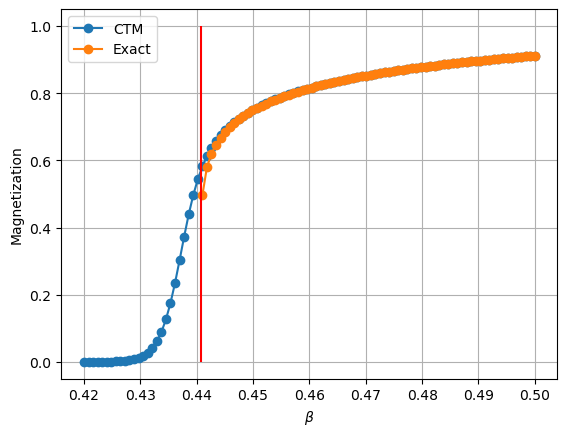

In [7]:
plt.plot(x,list_mag,'o-',label='CTM')
plt.plot(x,exact_mag(x),'o-',label='Exact')
plt.vlines(np.log(1 + np.sqrt(2))/2.,0,1,'r')
plt.xlabel(r'$\beta$')
plt.ylabel('Magnetization')
plt.legend()
plt.grid()

## The critical point

You can try to see what happens at the critical point (or close to it) if you increase the bond dimension



In [8]:
d_tol=1.e-10

numiter=100
list_mag=[]
beta_start=0.42
b_fin=0.5
num_steps=100
d=2
beta = np.log(1+np.sqrt(2))/2+0.001
a=local_tensor_T(beta,0)
b=a.copy()
b[1,:,:,:]=-b[1,:,:,:]
C = a[:,:,0,0]
T = a[:,:,0,:]
chi = d
T = T+T.transpose([2,1,0])
norm = compute_norm(C,T,a)
C= C/norm**(1/9)
T = T/norm**(1/9)
for chi_max in [4,8,16,32,64]:
    for k in range(numiter+1):
        C,T,chi = one_step_ctm(C,T,a,d,chi,chi_max,d_tol)
        norm = compute_norm(C,T,a)
        C= C/norm**(1/9)
        T = T/norm**(1/9)
        magnetization = compute_mag(C,T,a,b)
        norm = compute_norm(C,T,a)
        print(k,norm, magnetization,chi)
    list_mag.append(magnetization)


0 1.194235410350794 0.8472828991954657 4
1 1.4839516204163765 0.8127200736880831 4
2 1.4497061753356604 0.7882169993537133 4
3 1.4544339398912491 0.7694305178188265 4
4 1.4547546821281512 0.7543194239940835 4
5 1.4554790472076484 0.7417660473844623 4
6 1.4560880188824203 0.7310928374215844 4
7 1.4566504579600439 0.7218582870806691 4
8 1.4571670649923338 0.7137588016321998 4
9 1.457644322205696 0.7065767475233303 4
10 1.4580868148946493 0.7001508505874108 4
11 1.4584984127459524 0.6943583213295073 4
12 1.4588823555653 0.6891035422214254 4
13 1.45924139611639 0.6843106243333122 4
14 1.4595778955798129 0.6799183471239024 4
15 1.4598938966625832 0.6758766210827646 4
16 1.4601911798055758 0.6721439546660636 4
17 1.4604713072302116 0.6686856018996257 4
18 1.4607356579237945 0.6654721824781265 4
19 1.460985455760072 0.6624786368536856 4
20 1.461221792337437 0.6596834233255428 4
21 1.4614456456991367 0.6570678929172802 4
22 1.4616578958061597 0.6546157968578165 4
23 1.4618593374234543 0.652312

99 1.4698393627681778 0.5800510643155028 8
100 1.4698545428657552 0.5799399329958063 8
0 1.4698694900354772 0.5798308200997928 16
1 1.4698842871794735 0.5797234641831169 16
2 1.4698989363067838 0.5796177589804423 16
3 1.4699134620609646 0.579513595152815 16
4 1.4699278541753846 0.579410893268865 16
5 1.4699421084297244 0.579309560980781 16
6 1.4699562262449692 0.5792095184143483 16
7 1.4699702127325374 0.579110708967376 16
8 1.4699840747839494 0.5790130937541119 16
9 1.4699978197877315 0.5789166422996924 16
10 1.4700114548675427 0.5788213254598243 16
11 1.4700249864806627 0.5787271116562642 16
12 1.4700384202410184 0.5786339657074479 16
13 1.4700517608736385 0.5785418492308307 16
14 1.4700650122414889 0.5784507217974915 16
15 1.4700781774091072 0.5783605423065922 16
16 1.4700912587222668 0.5782712702810349 16
17 1.4701042578919523 0.5781828669435808 16
18 1.4701171760764775 0.5780952960281779 16
19 1.4701300139584619 0.5780085243333386 16
20 1.4701427718153603 0.5779225220493689 16
21 

87 1.4711362423848604 0.5714186398615911 32
88 1.47113792688286 0.5714081826064044 32
89 1.4711395897141726 0.57139786365495 32
90 1.4711412311498249 0.571387681190692 32
91 1.471142851457477 0.5713776334220854 32
92 1.4711444509014702 0.5713677185821249 32
93 1.4711460297428847 0.5713579349279028 32
94 1.4711475882395817 0.5713482807401729 32
95 1.4711491266462582 0.5713387543229438 32
96 1.4711506452144798 0.5713293540030727 32
97 1.4711521441927529 0.5713200781298732 32
98 1.471153623826532 0.5713109250747341 32
99 1.4711550843582977 0.5713018932307539 32
100 1.4711565260275736 0.571292981012381 32
0 1.4711579490720874 0.5712841868507658 64
1 1.471159353728031 0.5712755092003823 64
2 1.4711607402273967 0.5712669465349508 64
3 1.471162108798596 0.571258497344439 64
4 1.4711634596676402 0.5712501601445509 64
5 1.4711647930567484 0.5712419334742476 64
6 1.471166109185606 0.5712338158902399 64
7 1.471167408271642 0.5712258059645405 64
8 1.471168690530043 0.5712179022846778 64
9 1.471169

## Finite entanglement scaling
And plot the deviation from the exact magnetization in log-log scale with respect to the bond dimension $\chi$ to unveil the ***finite entanglement scaling***

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


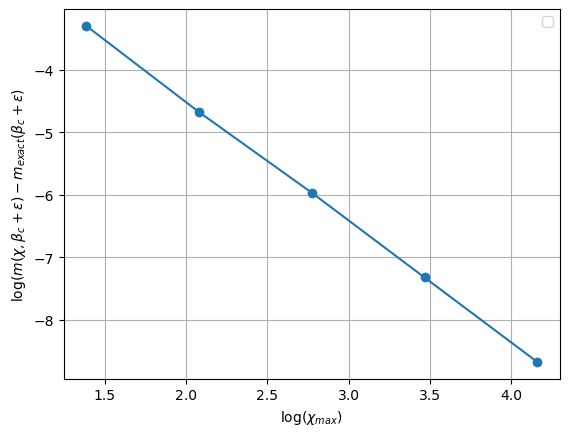

In [9]:
plt.plot(np.log([4,8,16,32,64]),np.log(list_mag-exact_mag(beta)),'o-')
plt.xlabel(r'$\log(\chi_{max})$')
plt.ylabel(r'$\log(m(\chi,\beta_c+\epsilon)-m_{exact}(\beta_c+\epsilon)$')
plt.legend()
plt.grid()